In [1]:
import json
from pathlib import Path
import random
import pprint

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 120

import os

import torch

from config import load_config
from data import build_datasets
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax


pp = pprint.PrettyPrinter(indent=2)

2024-06-13 10:35:04.678609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-06-13 10:35:04.678648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [3]:
# exp_name = 'multimodal-pretraining-v3--mlm_probability=0.15' 
# exp_name = 'multimodal-pretraining-v3--n_colors=139--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--vit--mlm_probability=0.15'

title_exp_names = {
    'multimodal-pretraining-v3--mlm_probability=0.15' : 'Base (8 Colors)',
    'multimodal-pretraining-v3--n_colors=139--mlm_probability=0.15' : '139 Colors Dataset A',
    'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15' : '139 Colors',
    'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15' : '216 Colors',
    'multimodal-pretraining-v3--vit--mlm_probability=0.15' : '8 Colors Vit Encoder',
    'multimodal-pretraining-v3--n_colors=139b_to_8_by_random--mlm_probability=0.15': '139 Colors with Label Pooling',
    'multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15': '216 Colors with Label Pooling',
}#[exp_name]

# resume_from_path = f'outputs/{exp_name}/last.ckpt'
# # resume_from_path = f'outputs/{exp_name}/last-v1.ckpt'

# checkpoint = torch.load(resume_from_path)

# print('Epoch:', checkpoint['epoch'])

In [4]:
results_dir = Path('outputs/results/')
all_results = [
    {'exp_name': p.stem, **json.load(p.open())} for p in results_dir.glob('*.json') 
]

In [5]:
# pp.pprint(vars(config))

In [6]:
all_results

[{'exp_name': 'multimodal-pretraining-v3--mlm_probability=0.15',
  'selected': {'color': [{'test_loss/dataloader_idx_0': 0.29279279708862305,
     'test_acc/dataloader_idx_0': 0.81983882188797,
     'test_mr/dataloader_idx_0': 1.2055670022964478,
     'test_mrr/dataloader_idx_0': 0.9061336517333984,
     'test_gt_prob/dataloader_idx_0': 0.8135273456573486,
     'test_rel_gt_prob/dataloader_idx_0': 0.9589321613311768,
     'test_acc@5%/dataloader_idx_0': 0.9990496039390564,
     'test_acc@10%/dataloader_idx_0': 0.9999894499778748},
    {'systematic_test_loss/dataloader_idx_1': 3.4336791038513184,
     'systematic_test_acc/dataloader_idx_1': 0.5220752358436584,
     'systematic_test_mr/dataloader_idx_1': 2.389667510986328,
     'systematic_test_mrr/dataloader_idx_1': 0.6819360852241516,
     'systematic_test_gt_prob/dataloader_idx_1': 0.5097808241844177,
     'systematic_test_rel_gt_prob/dataloader_idx_1': 0.622255802154541,
     'systematic_test_acc@5%/dataloader_idx_1': 0.8469297885894

## Base Dataset

In [7]:
base_result = [r for r in all_results if r['exp_name'] == 'multimodal-pretraining-v3--mlm_probability=0.15'][0]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


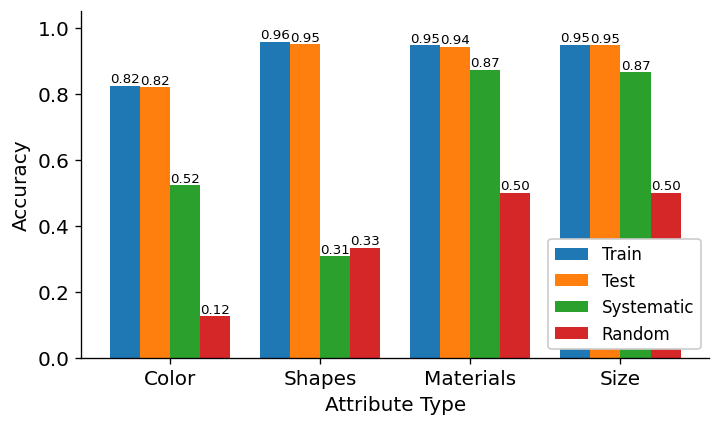

In [8]:
results = base_result['selected']
categories = results.keys()
category_labels = [c.capitalize() for c in results.keys()]
values1 = [results[cat][0]['test_acc/dataloader_idx_0'] for cat in categories]
values2 = [results[cat][1]['systematic_test_acc/dataloader_idx_1'] for cat in categories]
values0 = [results[cat][2]['train_acc/dataloader_idx_0'] for cat in categories]
valuesR = [base_result['random_baseline'][cat] for cat in categories]

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.2

# Create bars for each category
bar_train = plt.bar([x - 1.5*bar_width for x in range(len(categories))], values0, width=bar_width, label='Train')
bar_test = plt.bar([x - 0.5*bar_width for x in range(len(categories))], values1, width=bar_width, label='Test')
bar_syst = plt.bar([x + 0.5*bar_width for x in range(len(categories))], values2, width=bar_width, label='Systematic')
bar_random = plt.bar([x + 1.5*bar_width for x in range(len(categories))], valuesR, width=bar_width, label='Random')

xs =  list(range(len(categories)))
for i, (v0, v1, v2, vr) in enumerate(zip(values0, values1,values2, valuesR)):
    plt.text(xs[i] - 1.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] - 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] + 0.5*bar_width, v2 + 0.01, f'{v2:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] + 1.5*bar_width, vr + 0.01, f'{vr:.2f}', ha='center', fontsize=8)

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Attribute Type')
plt.ylabel('Accuracy')
plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(categories)), category_labels)
plt.legend(framealpha=1, loc='lower right')

# Show plot
plt.savefig('exports/base-attributes.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
train_color = bar_train[0].get_facecolor()
test_color = bar_test[0].get_facecolor()
syst_color = bar_syst[0].get_facecolor()
random_color = bar_random[0].get_facecolor()

In [10]:
categories

dict_keys(['color', 'shapes', 'materials', 'size'])

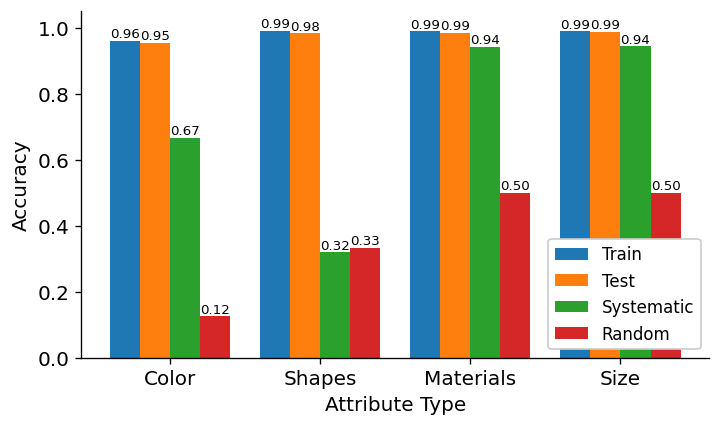

In [11]:
results = base_result['random']
categories = results.keys()
category_labels = [c.capitalize() for c in results.keys()]
values1 = [results[cat][0]['test_acc/dataloader_idx_0'] for cat in categories]
values2 = [results[cat][1]['systematic_test_acc/dataloader_idx_1'] for cat in categories]
values0 = [results[cat][2]['train_acc/dataloader_idx_0'] for cat in categories]
valuesR = [base_result['random_baseline'][cat] for cat in categories]

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.2

# Create bars for each category
plt.bar([x - 1.5*bar_width for x in range(len(categories))], values0, width=bar_width, label='Train', color=train_color)
plt.bar([x - 0.5*bar_width for x in range(len(categories))], values1, width=bar_width, label='Test', color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(categories))], values2, width=bar_width, label='Systematic', color=syst_color)
plt.bar([x + 1.5*bar_width for x in range(len(categories))], valuesR, width=bar_width, label='Random', color=random_color)

xs =  list(range(len(categories)))
for i, (v0, v1, v2, vr) in enumerate(zip(values0, values1,values2, valuesR)):
    plt.text(xs[i] - 1.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] - 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] + 0.5*bar_width, v2 + 0.01, f'{v2:.2f}', ha='center', fontsize=8)
    plt.text(xs[i] + 1.5*bar_width, vr + 0.01, f'{vr:.2f}', ha='center', fontsize=8)

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Attribute Type')
plt.ylabel('Accuracy')
plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(categories)), category_labels)
plt.legend(framealpha=1, loc='lower right')

# Show plot
plt.show()

## New colors

In [12]:
new_colors_exps_names = [
    'multimodal-pretraining-v3--mlm_probability=0.15',
    'multimodal-pretraining-v3--n_colors=70b--mlm_probability=0.15',
    'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15',
    'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15',
]
new_colors_results = [r for r in all_results if r['exp_name'] in new_colors_exps_names]

In [13]:
def read_metric(result, category, metric):
    if metric == 'random_baseline':
        return result['random_baseline'][category]
    
    metric_idx, metric_name = {
        f'test_acc': (0, 'test_acc/dataloader_idx_0'),
        f'systematic_test_acc': (1, 'systematic_test_acc/dataloader_idx_1'),
        f'train_acc': (2, 'train_acc/dataloader_idx_0'),
    }[metric]
    
    return result['selected'][category][metric_idx][metric_name]

def get_num_colors(base_path):
    if 'colored' not in base_path:
        return 8
    num_colors = int(base_path.split('/')[-1][:-1])
    return num_colors

In [14]:
new_colors_results = sorted(new_colors_results, key=lambda r: get_num_colors(r['config']['base_path']))

In [15]:
num_colors = [get_num_colors(r['config']['base_path']) for r in new_colors_results]
categories = ['colors', 'shapes']
category_labels = [c.capitalize() for c in categories]

color_tests = [read_metric(r, 'color', 'test_acc') for r in new_colors_results] 
color_system = [read_metric(r, 'color', 'systematic_test_acc') for r in new_colors_results] 
color_random = [read_metric(r, 'color', 'random_baseline') for r in new_colors_results] 
shape_tests = [read_metric(r, 'shapes', 'test_acc') for r in new_colors_results] 
shape_system = [read_metric(r, 'shapes', 'systematic_test_acc') for r in new_colors_results] 
shape_random = [read_metric(r, 'shapes', 'random_baseline') for r in new_colors_results] 

In [16]:
test_color, syst_color

((1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0))

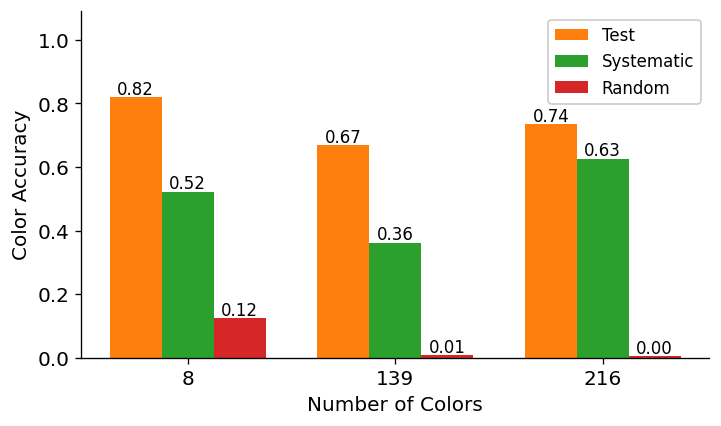

In [17]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.25

# Create bars for each category
plt.bar([x - 1*bar_width for x in range(len(num_colors))], color_tests, width=bar_width, label='Test', color=test_color)
plt.bar([x + 0*bar_width for x in range(len(num_colors))], color_system, width=bar_width, label='Systematic', color=syst_color)
plt.bar([x + 1*bar_width for x in range(len(num_colors))], color_random, width=bar_width, label='Random', color=random_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1, vr) in enumerate(zip(color_tests, color_system, color_random)):
    plt.text(xs[i] - 1*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')
    plt.text(xs[i] + 1*bar_width, vr + 0.01, f'{vr:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Color Accuracy')
plt.ylim(0., 1.09)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(num_colors)), num_colors)
plt.legend(framealpha=1, loc='upper right')

# Show plot
plt.savefig('exports/acc-colors-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

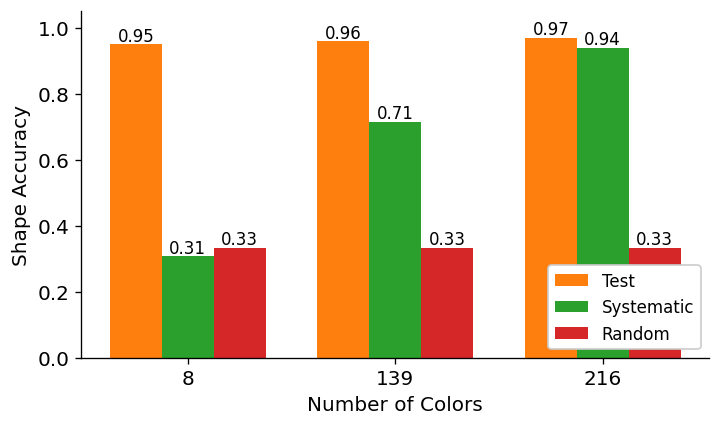

In [18]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.25

# Create bars for each category
plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test', color=test_color)
plt.bar([x + 0*bar_width for x in range(len(num_colors))], shape_system, width=bar_width, label='Systematic', color=syst_color)
plt.bar([x + 1*bar_width for x in range(len(num_colors))], shape_random, width=bar_width, label='Random', color=random_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1, vr) in enumerate(zip(shape_tests, shape_system, shape_random)):
    plt.text(xs[i] - 1*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')
    plt.text(xs[i] + 1*bar_width, vr + 0.01, f'{vr:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(num_colors)), num_colors)
plt.legend(framealpha=1, loc='lower right')

# Show plot
plt.savefig('exports/acc-shapes-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

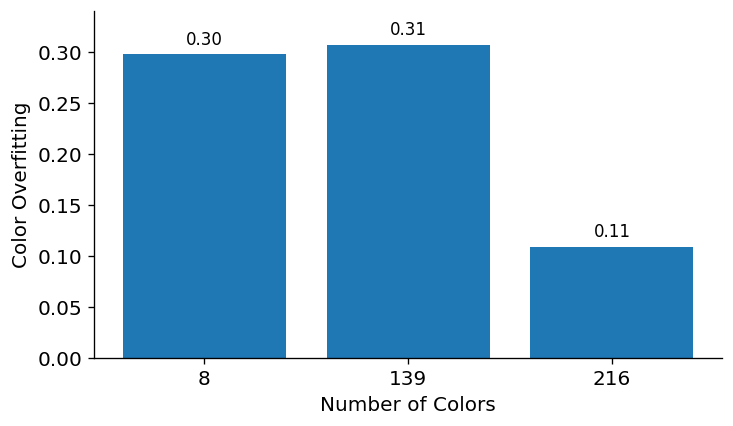

In [19]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.5

color_diff = np.array(color_tests) - np.array(color_system)
# Create bars for each category
plt.bar([x for x in range(len(num_colors))], color_diff)

xs =  list(range(len(num_colors)))
for i, v0 in enumerate(color_diff):
    plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Color Overfitting')
plt.ylim(0., 0.34)
plt.xticks(range(len(num_colors)), num_colors)

# Show plot
plt.savefig('exports/diff-colors-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

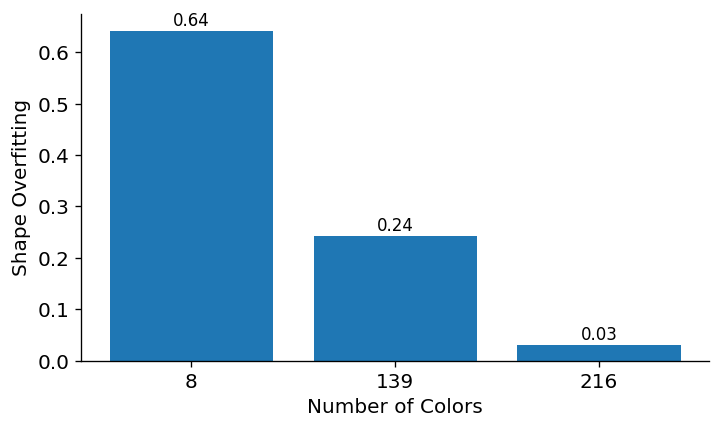

In [20]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.5

shape_diff = np.array(shape_tests) - np.array(shape_system)
# Create bars for each category
plt.bar([x for x in range(len(num_colors))], shape_diff)

xs =  list(range(len(num_colors)))
for i, v0 in enumerate(shape_diff):
    plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Shape Overfitting')
# plt.ylim(0., 1.05)
plt.xticks(range(len(num_colors)), num_colors)

# Show plot
plt.savefig('exports/diff-shapes-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
from itertools import product

pre = 'multimodal-pretraining-v3'
suf = 'mlm_probability=0.15'
lo_exps_names = [
#     f'{pre}--{suf}',
    *[f'{pre}--n_colors={cnum}--{suf}' for cnum in ['70b','139b','216b']],
    *[f'{pre}--n_colors={cnum}_to_{lo_num}_by_random--{suf}' 
          for cnum, lo_num in product(['70b','139b','216b'], ['4','8'])],
]
lo_results = [r for r in all_results if r['exp_name'] in lo_exps_names]

In [22]:
def get_num_clusters(r):
    if not r['config'].get('token_translation_path'):
        return get_num_colors(r['config']['base_path'])
    return int(r['config']['token_translation_path'].replace('.json','').split('to_')[-1])

In [23]:
lo_results = sorted(lo_results, key=lambda r: (get_num_colors(r['config']['base_path']), -get_num_clusters(r)))

In [24]:
num_colors = [get_num_colors(r['config']['base_path']) for r in lo_results]
num_clusters = [get_num_clusters(r) for r in lo_results]
uniq_num_colors = sorted(list(set(num_colors)))
categories = ['colors', 'shapes']
category_labels = [c.capitalize() for c in categories]

color_tests = [read_metric(r, 'color', 'test_acc') for r in lo_results] 
color_system = [read_metric(r, 'color', 'systematic_test_acc') for r in lo_results] 

shape_tests = [read_metric(r, 'shapes', 'test_acc') for r in lo_results] 
shape_system = [read_metric(r, 'shapes', 'systematic_test_acc') for r in lo_results] 

In [25]:
all_overfitting_color = []
all_overfitting_shape = []
all_num_colors = []
all_num_clusters = []
all_color_test_acc = []
all_color_systematic_test_acc = []
all_shapes_test_acc = []
all_shapes_systematic_test_acc = []

for num in uniq_num_colors:
    overfitting_color = []
    overfitting_shape = []
    num_colors = []
    num_clusters = []
    color_test_acc = []
    color_systematic_test_acc = []
    shapes_test_acc = []
    shapes_systematic_test_acc = []
    for r in lo_results:
        if get_num_colors(r['config']['base_path']) != num:
            continue
        c_test_acc = read_metric(r, 'color', 'test_acc')
        c_systematic_test_acc = read_metric(r, 'color', 'systematic_test_acc')
        s_test_acc = read_metric(r, 'shapes', 'test_acc')
        s_systematic_test_acc = read_metric(r, 'shapes', 'systematic_test_acc')
        
        color_test_acc.append(c_test_acc)
        color_systematic_test_acc.append(c_systematic_test_acc)
        shapes_test_acc.append(s_test_acc)
        shapes_systematic_test_acc.append(s_systematic_test_acc)
        overfitting_color.append(
            c_test_acc - c_systematic_test_acc)
        overfitting_shape.append(
            s_test_acc - s_systematic_test_acc)
        num_colors.append(get_num_colors(r['config']['base_path']))
        num_clusters.append(get_num_clusters(r))

    all_color_test_acc.append(color_test_acc)
    all_color_systematic_test_acc.append(color_systematic_test_acc)
    all_shapes_test_acc.append(shapes_test_acc)
    all_shapes_systematic_test_acc.append(shapes_systematic_test_acc)
    all_overfitting_color.append(overfitting_color)
    all_overfitting_shape.append(overfitting_shape)
    all_num_colors.append(num_colors)
    all_num_clusters.append(num_clusters)

In [26]:
all_num_colors, all_num_clusters, all_overfitting_shape

([[139, 139], [216, 216]],
 [[139, 8], [216, 8]],
 [[0.24338769912719727, 0.033498525619506836],
  [0.03053802251815796, 0.004287302494049072]])

In [27]:
t_all_overfitting_shape = list(zip(*all_overfitting_shape))
t_all_overfitting_color = list(zip(*all_overfitting_color))

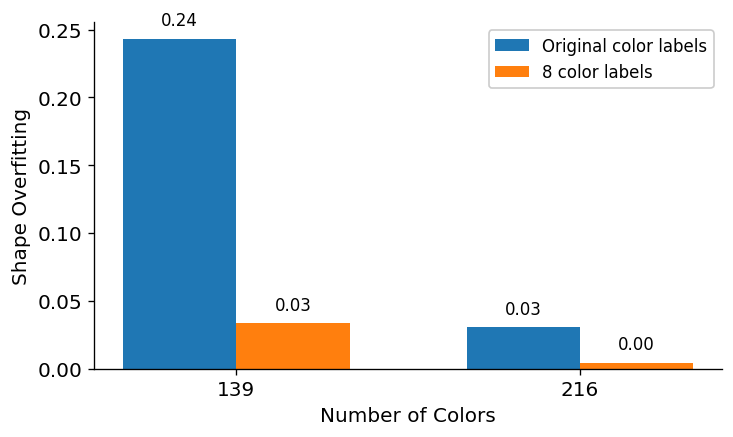

In [28]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        t_all_overfitting_shape[0],
        width=bar_width,
        label='Original color labels',
        )
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        t_all_overfitting_shape[1],
        width=bar_width,
        label='8 color labels',
        )

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(*t_all_overfitting_shape)):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Shape Overfitting')
# plt.ylim(0., 0.34)
plt.xticks(range(len(uniq_num_colors)), uniq_num_colors)
plt.legend(framealpha=1, loc='upper right')

# Show plot
plt.savefig('exports/diff-shapes-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

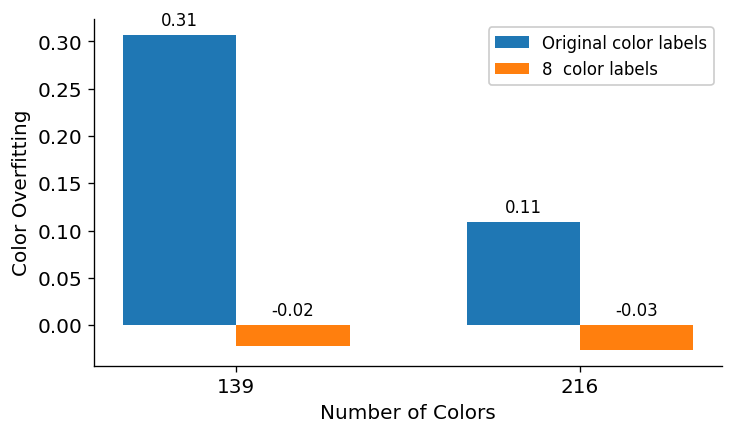

In [29]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        t_all_overfitting_color[0],
        width=bar_width,
        label='Original color labels')
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        t_all_overfitting_color[1],
        width=bar_width,
        label='8  color labels')

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(*t_all_overfitting_color)):
    plt.text(xs[i] - 0.5*bar_width, max(0,v0) + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, max(0,v1) + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
# plt.title(title_exp_names[base_result['exp_name']])
plt.xlabel('Number of Colors')
plt.ylabel('Color Overfitting')
# plt.ylim(0., 0.34)
plt.xticks(range(len(uniq_num_colors)), uniq_num_colors)
plt.legend(framealpha=1, loc='upper right')

# Show plot
plt.savefig('exports/diff-colors-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
t_all_color_test_acc = list(zip(*all_color_test_acc))
t_all_color_systematic_test_acc = list(zip(*all_color_systematic_test_acc))
t_all_shapes_test_acc = list(zip(*all_shapes_test_acc))
t_all_shapes_systematic_test_acc = list(zip(*all_shapes_systematic_test_acc))

In [31]:
all_color_test_acc

[[0.668540358543396, 0.7436622381210327],
 [0.7350098490715027, 0.7666332125663757]]

In [32]:
test_color, syst_color

((1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


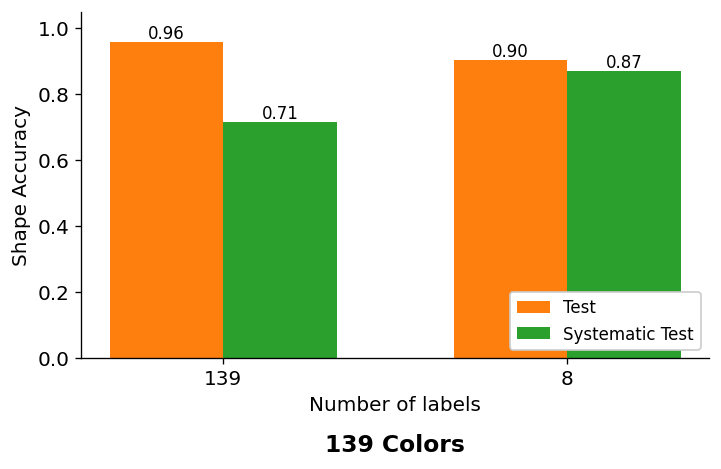

In [33]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_shapes_test_acc[0],
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_shapes_systematic_test_acc[0],
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(all_shapes_test_acc[0], all_shapes_systematic_test_acc[0])):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
plt.title("139 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
plt.xticks(range(len(uniq_num_colors)), all_num_clusters[0])
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-shapes-by-label-overloading-1.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

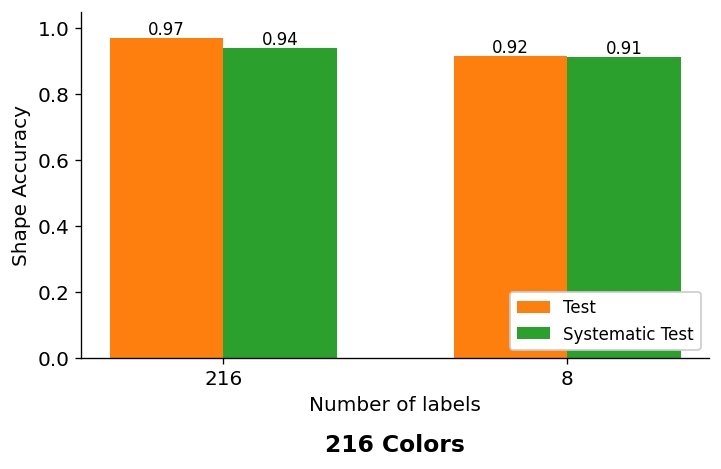

In [34]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_shapes_test_acc[1],
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_shapes_systematic_test_acc[1],
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(all_shapes_test_acc[1], all_shapes_systematic_test_acc[1])):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
plt.title("216 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
plt.xticks(range(len(uniq_num_colors)), all_num_clusters[1])
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-shapes-by-label-overloading-2.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

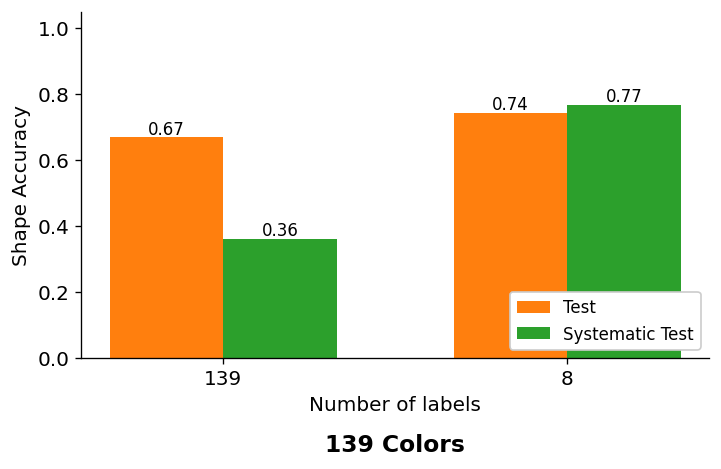

In [35]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_color_test_acc[0],
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_color_systematic_test_acc[0],
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(all_color_test_acc[0], all_color_systematic_test_acc[0])):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
plt.title("139 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
plt.xticks(range(len(uniq_num_colors)), all_num_clusters[0])
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-colors-by-label-overloading-1.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

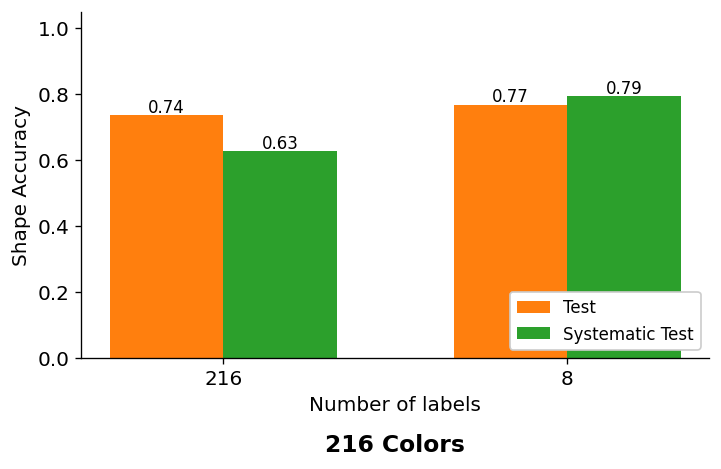

In [36]:
from itertools import chain 

flat_num_clusters = list(chain(*all_num_clusters))

plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_color_test_acc[1],
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(uniq_num_colors))],
        all_color_systematic_test_acc[1],
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(num_colors)))
for i, (v0, v1) in enumerate(zip(all_color_test_acc[1], all_color_systematic_test_acc[1])):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
plt.title("216 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
plt.xticks(range(len(uniq_num_colors)), all_num_clusters[1])
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-colors-by-label-overloading-2.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
from itertools import chain 

flat_num_colors = list(chain(*all_num_colors))
flat_num_clusters = list(chain(*all_num_clusters))
flat_color_test_acc = list(chain(*all_color_test_acc))
flat_color_systematic_test_acc = list(chain(*all_color_systematic_test_acc))
flat_shapes_test_acc = list(chain(*all_shapes_test_acc))
flat_shapes_systematic_test_acc = list(chain(*all_shapes_systematic_test_acc))

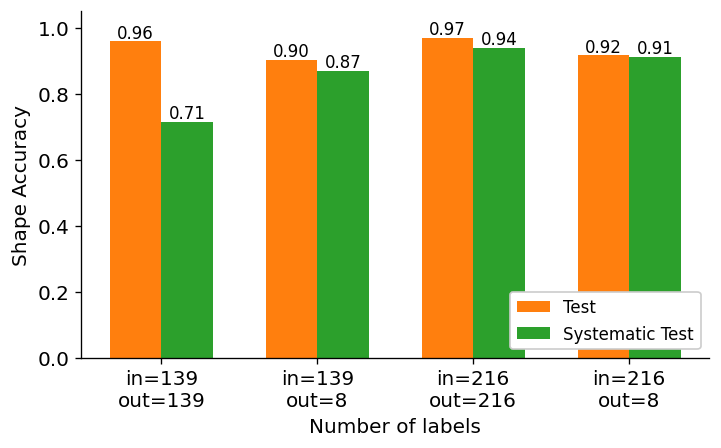

In [43]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(flat_num_colors))],
        flat_shapes_test_acc,
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(flat_num_colors))],
        flat_shapes_systematic_test_acc,
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(flat_num_colors)))
for i, (v0, v1) in enumerate(zip(flat_shapes_test_acc, flat_shapes_systematic_test_acc)):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
# plt.title("139 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Shape Accuracy')
plt.ylim(0., 1.05)
label_fn = lambda x: f'in={x[0]}\nout={x[1]}'
plt.xticks(range(len(flat_num_colors)), map(label_fn, zip(flat_num_colors, flat_num_clusters)))
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-shapes-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

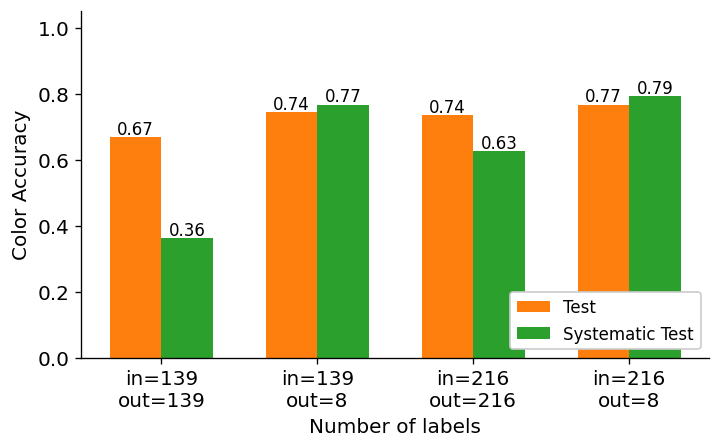

In [44]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.33

# Create bars for each category
# plt.bar([x - 1*bar_width for x in range(len(num_colors))], shape_tests, width=bar_width, label='Test')
plt.bar([x - 0.5*bar_width for x in range(len(flat_num_colors))],
        flat_color_test_acc,
        width=bar_width,
        label='Test',
        color=test_color)
plt.bar([x + 0.5*bar_width for x in range(len(flat_num_colors))],
        flat_color_systematic_test_acc,
        width=bar_width,
        label='Systematic Test',
        color=syst_color)

xs =  list(range(len(flat_num_colors)))
for i, (v0, v1) in enumerate(zip(flat_color_test_acc, flat_color_systematic_test_acc)):
    plt.text(xs[i] - 0.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')

# Add labels and title
# plt.title("139 Colors", y=-0.3, fontdict={'fontweight':'bold'})
plt.xlabel('Number of labels')
plt.ylabel('Color Accuracy')
plt.ylim(0., 1.05)
label_fn = lambda x: f'in={x[0]}\nout={x[1]}'
plt.xticks(range(len(flat_num_colors)), map(label_fn, zip(flat_num_colors, flat_num_clusters)))
plt.legend(framealpha=1, loc='lower right')



# Show plot
plt.savefig('exports/acc-colors-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
assert False

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 assert False                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [ ]:
idx = 30
question = train_dataset.questions[idx]
image_idx = question['image_index']
scene = train_dataset.indexed_scenes[image_idx]

question_str = question['question']
answer_str = question['answer']

In [ ]:
config.rels_to_sample = 0
config.only_front_right_relations = False
config.filter_symmetric_relations = True
config.display_object_properties = False

s = Scene.from_dict(scene,
                    shuffle_relations=True,
                    relations_to_sample=config.rels_to_sample,
                    only_front_right=config.only_front_right_relations,
                    filter_symmetric=config.filter_symmetric_relations,
                    always_display_properties=config.display_object_properties)

In [ ]:
config.rels_to_sample, config.only_front_right_relations, config.filter_symmetric_relations, config.display_object_properties

In [ ]:
len(s.relations), list(enumerate(s.relations))

In [ ]:
s.objects

In [ ]:
str(s)

In [ ]:
relations_to_sample = 20
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=relations_to_sample,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
max(n_tokens)

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']
    
    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = True

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
dataset_path = Path('/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0')
scenes_path = dataset_path / 'scenes/CLEVR_trainA_scenes.json'
with scenes_path.open('r') as fp:
    scenes = json.load(fp)
    
questions_path = dataset_path / 'questions/CLEVR_trainA_questions.json'
with questions_path.open('r') as fp:
    questions = json.load(fp)

In [ ]:
questions['questions'][3]

In [ ]:
def n_relations(scene):
    relations = ['behind', 'front']#, 'left', 'right']
    count = 0
    relationships = scene['relationships']
    for r in relations:
        count += sum(map(len, relationships[r]))
    return count

n_relations(scenes['scenes'][0])

In [ ]:
(scenes['scenes'][0])

In [ ]:
n_relations_per_example = list(map(n_relations, scenes['scenes']))
plt.hist(n_relations_per_example)
plt.plot()

In [ ]:
def n_objects(scene):
    return len(scene['objects'])

In [ ]:
n_objects_per_example = list(map(n_objects, scenes['scenes']))
plt.hist(n_objects_per_example, bins=max(n_objects_per_example)-3)
plt.plot()

In [ ]:
def object_to_text(obj, obj_idx):
    properties = ['size', 'color', 'material', 'shape']
    obj_str = [f'[O{obj_idx}]'] + [obj[prop] for prop in properties]
    return ' '.join(obj_str)

def relations_to_text(relations):
#     relation_types = ['behind', 'front', 'left', 'right']
    relation_types = ['front', 'right'] # symetric relations

    relations_str = []
    for relation_type in relation_types:
        relation = relations[relation_type]
        for obj, subjs in enumerate(relation):
            relation_str = [f'[O{obj}] {relation_type} [O{subj}]' for subj in subjs]
            relations_str.extend(relation_str)
    
    return relations_str

def scene_to_txt(scene, rels_to_sample=None, shuffle=True):
    objs_strs = []
    for obj_idx, obj in enumerate(scene['objects']):
        objs_strs.append(object_to_text(obj, obj_idx=obj_idx))
    
    relations_strs = relations_to_text(scene['relationships'])
    if rels_to_sample and rels_to_sample < len(relations_strs):
        relations_strs = random.sample(relations_strs, k)
    if shuffle:
        random.shuffle(relations_strs)

    return ' [SEP] '.join(objs_strs + relations_strs)

In [ ]:
from PIL import Image
ip = '/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0/images/trainA/' + questions['questions'][8888]['image_filename']
Image.open(ip)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][0], obj_idx=0)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][1], obj_idx=1)

In [ ]:
relations_to_text(scenes['scenes'][8888]['relationships'])

In [ ]:
scene_to_txt(scenes['scenes'][8888])

In [ ]:
# scene_to_txt(scenes['scenes'][8888], rels_to_sample=5)

In [ ]:
to_str = lambda s: str(Scene.from_dict(s, 
                                        relations_to_sample=config.rels_to_sample,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(to_str, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
str_fnc = lambda s: str(Scene.from_dict(s, relations_to_sample=50,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(str_fnc, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
vocabulary = set()
for scene in scenes['scenes']:
    scene_text = scene_to_txt(scene)
    vocabulary.update(scene_text.split())

vocabulary = ['[CLS]', '[PAD]'] + list(sorted(vocabulary))

In [ ]:
len(vocabulary), vocabulary